<a href="https://colab.research.google.com/github/shrudh-i/10703-drl/blob/main/F24_703_HW3/code/10_403_HW3Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup: Import Dependencies
Run the cell below to import the relevant dependencies.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import functools
import math

### Part 1: CMA-ES
Implement CMA-ES below.

In [2]:
def cmaes(fn, dim, num_iter=10):
  """Optimizes a given function using CMA-ES.

  Args:
    fn: A function that takes as input a vector and outputs a scalar value.
    dim: (int) The dimension of the vector that fn expects as input.
    num_iter: (int) Number of iterations to run CMA-ES.

  Returns:
    mu_vec: An array of size [num_iter, dim] storing the value of mu at each
      iteration.
    best_sample_vec: A list of length [num_iter] storing the function value
      for the best sample from each iteration of CMA-ES.
    mean_sample_vec: A list of length [num_iter] storing the average function
      value across samples from each iteration of CMA-ES.
  """
  # Hyperparameters
  sigma = 10
  population_size = 100
  p_keep = 0.10  # Fraction of population to keep
  noise = 0.25  # Noise added to covariance to prevent it from going to 0.

  # Initialize the mean and covariance
  mu = np.zeros(dim)
  cov = sigma**2 * np.eye(dim)

  mu_vec = []
  best_sample_vec = []
  mean_sample_vec = []

  for t in range(num_iter):
    # WRITE CODE HERE

    mu_vec.append(mu)
    # Generate random x
    samples = np.random.multivariate_normal(mu, cov, population_size).squeeze()
    scores = []

    # Calculate the score for each sample of x
    for s in samples:
      scores.append(fn(s))

    # Select top k(=pop_size*p_keep) parameters with the highest score
    elite_size = int(population_size*p_keep)
    top_k = np.argsort(scores)[-elite_size:]

    idx = np.argmax(scores)
    highest_score = scores[idx]
    highest_sample = samples[idx]
    best_sample_vec.append(highest_score)

    mean_sample_vec.append(np.mean(scores))
    # Update the mean and std dev
    mu = np.mean(samples[top_k], axis=0)
    cov = np.cov(samples[top_k], rowvar=False) + (noise) *np.eye(dim)


  return mu_vec, best_sample_vec, mean_sample_vec

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In the cell below, we've defined a simply function:
$$f(x) = -\|x - x^*\|_2^2 \quad \text{where} \quad x^* = [65, 49].$$
This function is optimized when $x = x^*$. Run your implementation of CMA-ES on this function, confirming that you get the correct solution.

In [3]:
def test_fn(x):
  goal = np.array([65, 49])
  return -np.sum((x - goal)**2)

mu_vec, best_sample_vec, mean_sample_vec = cmaes(test_fn, dim=2, num_iter=100)

Run the following cell to visualize CMA-ES.

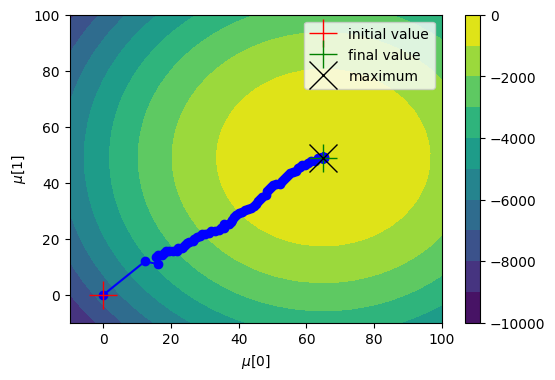

In [5]:
x = np.stack(np.meshgrid(np.linspace(-10, 100, 30), np.linspace(-10, 100, 30)), axis=-1)
fn_value = [test_fn(xx) for xx in x.reshape((-1, 2))]
fn_value = np.array(fn_value).reshape((30, 30))
plt.figure(figsize=(6, 4))
plt.contourf(x[:, :, 0], x[:, :, 1], fn_value, levels=10)
plt.colorbar()
mu_vec = np.array(mu_vec)
plt.plot(mu_vec[:, 0], mu_vec[:, 1], 'b-o')
plt.plot([mu_vec[0, 0]], [mu_vec[0, 1]], 'r+', ms=20, label='initial value')
plt.plot([mu_vec[-1, 0]], [mu_vec[-1, 1]], 'g+', ms=20, label='final value')
plt.plot([65], [49], 'kx', ms=20, label='maximum')
plt.xlabel('$\mu[0]$')
plt.ylabel("$\mu[1]$")
plt.legend()
plt.savefig('q1_1.png')
plt.show()

**Next**, you will apply CMA-ES to a more complicating: maximizing the expected reward of a RL agent. The policy takes action LEFT with probability:
$$\pi(a = \text{LEFT} \mid s) = s \cdot w + b,$$
where $w \in \mathbb{R}^4$ and $b \in \mathbb{R}$ are parameters that you will optimize with CMA-ES. In the cell below, define a function that takes as input a single vector $x = (w, b)$ and the environment and returns the total (undiscounted) reward from one episode.

In [6]:
def _sigmoid(x):
  return 1 / (1 + np.exp(-x))

def _get_action(s, params):
  w = params[:4]
  b = params[4]
  p_left = _sigmoid(w @ s + b)
  a = np.random.choice(2, p=[p_left, 1 - p_left])
  return a

def rl_fn(params, env):
  assert len(params) == 5
  ## WRITE CODE HERE

  # generate a episode (random sample)
  state =  env.reset()
  total_rewards = 0
  while True:
    action = _get_action(state, params)
    new_state, reward, done, _ = env.step(action)

    state = new_state
    total_rewards += reward

    if done:
      break

  return total_rewards


The cell below applies your CMA-ES implementation to the RL objective you've defined in the cell above.

In [7]:
env = gym.make('CartPole-v0')
fn_with_env = functools.partial(rl_fn, env=env)

parameters_list = [(-1,-1,-1,-1,-1), ( 1, 0, 1, 0, 1), ( 0, 1, 2, 3, 4)]

print("\n\n1.2: TESTING IMPLEMENTATION OF FUNC FOR CARTPOLE")
for parameter in parameters_list:
  average_reward = 0
  for _ in range(1000):
    average_reward += rl_fn(parameter, env) / 1000
  print("Parameter", parameter, "with resulting reward:", f"{average_reward:.2f}")

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated,



1.2: TESTING IMPLEMENTATION OF FUNC FOR CARTPOLE
Parameter (-1, -1, -1, -1, -1) with resulting reward: 15.44
Parameter (1, 0, 1, 0, 1) with resulting reward: 14.24
Parameter (0, 1, 2, 3, 4) with resulting reward: 9.43


1.3: CMA-ES on RL Objective Function
[18.98, 63.34, 154.24, 179.77, 191.58, 193.51, 198.15, 189.36, 189.62, 198.38]
True


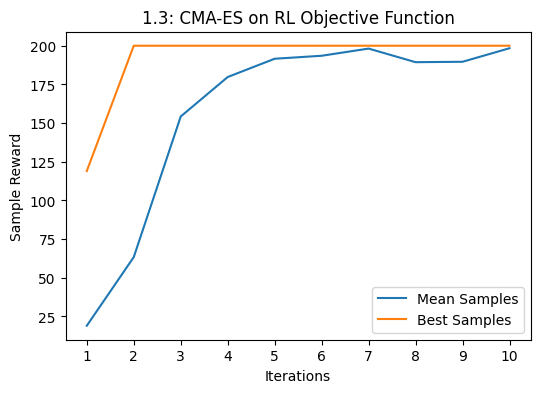

In [8]:
# 1.3: CMA-ES on RL Objective Function
print("1.3: CMA-ES on RL Objective Function")
mu_vec, best_sample_vec, mean_sample_vec = cmaes(fn_with_env, dim=5, num_iter=10)
print(mean_sample_vec)
print(max(mean_sample_vec) > 195.0)

# Plot Mean Sample Reward & Best Sample Reward (Y Axis) across Iterations (X Axis)
plt.figure(figsize=(6, 4))
x_axis = np.arange(10)+1
plt.plot(x_axis, mean_sample_vec, label="Mean Samples")
plt.plot(x_axis, best_sample_vec, label="Best Samples")
plt.xticks(x_axis)
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Sample Reward")
plt.title("1.3: CMA-ES on RL Objective Function")
plt.savefig('q1_3.png')
plt.show()